In [ ]:
import numpy as np
import pandas as pd
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objs as go
from plotly.offline import plot, iplot, init_notebook_mode;
from sklearn.preprocessing import StandardScaler
from collections import defaultdict
import altair as alt
from utils import scrape_data
from preprocess_times import times_preprocess,times_nation_top_100,times_univ_ranking_list,times_univ_dataframe
import math
from pyecharts.charts import *
from pyecharts import options as opts
from pyecharts.commons.utils import JsCode
from pyecharts.components import Table
from pyecharts.globals import ThemeType
import re

### DATA DESCRIPTION ###
#### We have used have used Times Higher Education, CWUR and Shanghai rankings from this [Kaggle dataset](https://www.kaggle.com/mylesoneill/world-university-rankings?select=educational_attainment_supplementary_data.csv)  and further scraped rankings for later years s needed. The educational spending data is from [UNESCO](http://data.uis.unesco.org/#)  data on government expenditure in post secondary and tertiary education and unsepcified level of education normalized for purchasing power parity, from 2010-2021 for all countries and  ####

#### EXPENDITURE ####

In [ ]:
# education expenditure data from Unesco
exp = pd.read_csv('data/education_expenditure.csv')
exp.head(10)

,NATMON_IND,Indicator,LOCATION,Country,TIME,Time,Value,Flag Codes,Flags
0,X_PPPCONST_UK_FSGOV,Government expenditure on education not specif...,SSD,South Sudan,2011,2011,NaN,n,Magnitude nil or negligible
1,X_PPPCONST_UK_FSGOV,Government expenditure on education not specif...,SSD,South Sudan,2013,2013,NaN,n,Magnitude nil or negligible
2,X_PPPCONST_UK_FSGOV,Government expenditure on education not specif...,SSD,South Sudan,2014,2014,NaN,n,Magnitude nil or negligible
3,X_PPPCONST_UK_FSGOV,Government expenditure on education not specif...,SSD,South Sudan,2015,2015,NaN,n,Magnitude nil or negligible
4,X_PPPCONST_UK_FSGOV,Government expenditure on education not specif...,SSD,South Sudan,2016,2016,NaN,n,Magnitude nil or negligible
5,X_PPPCONST_UK_FSGOV,Government expenditure on education not specif...,SSD,South Sudan,2017,2017,NaN,n,Magnitude nil or negligible
6,X_PPPCONST_4_FSGOV,Government expenditure on post-secondary non-t...,ISL,Iceland,2010,2010,NaN,n,Magnitude nil or negligible
7,X_PPPCONST_4_FSGOV,Government expenditure on post-secondary non-t...,ISL,Iceland,2011,2011,NaN,n,Magnitude nil or negligible
8,X_PPPCONST_4_FSGOV,Government expenditure on post-secondary non-t...,ISL,Iceland,2012,2012,8.34555,NaN,NaN
9,X_PPPCONST_4_FSGOV,Government expenditure on post-secondary non-t...,ISL,Iceland,2013,2013,8.43417,NaN,NaN


In [ ]:
exp = exp[['Value','Country','LOCATION', 'TIME','Indicator']].dropna()
exp = exp.rename(columns = {"Value":"educational_spending"})

<AxesSubplot:title={'center':'Educational spending in 2018'}, ylabel='Country'>

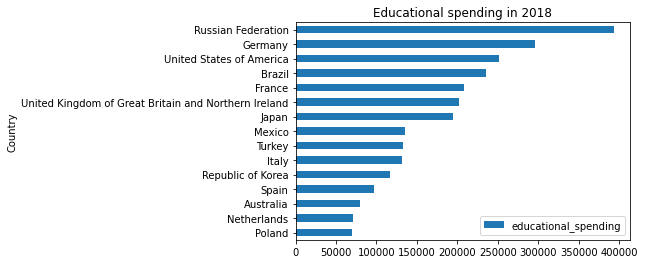

In [ ]:
# educatinal spending of different countries in 2018
x = exp[exp.TIME == 2018][['educational_spending','Country','LOCATION']]
# sum all kinds of expenses for each country
x.educational_spending = x[['educational_spending','LOCATION']].groupby('LOCATION').transform('sum')
x.drop_duplicates('LOCATION', inplace=True)
x = x.set_index('Country')
x.sort_values(by='educational_spending', ascending=False)[:15][::-1].plot(kind='barh', title='Educational spending in 2018')

#### Aggregate spending of all countries between 2013 and 2018 ####

In [ ]:
x = exp.query('2013 <= TIME <= 2018')
agg_exp = x[['educational_spending','LOCATION','TIME']]
agg_exp.educational_spending = agg_exp.educational_spending/agg_exp.groupby(['TIME'])['educational_spending'].transform('mean')*100
agg_exp.drop(['TIME'], axis=1, inplace=True)
agg_exp.educational_spending = agg_exp.groupby(['LOCATION'])['educational_spending'].transform('sum')
agg_exp = agg_exp.drop_duplicates(subset=['LOCATION'], keep='last').dropna(subset=['LOCATION'])

fig = px.choropleth(agg_exp, locations="LOCATION",
                    color="educational_spending",
                    hover_name="LOCATION", 
                    color_continuous_scale=px.colors.sequential.Viridis)
fig.show()

#### GERMANY - CASE STUDY ####

<AxesSubplot:title={'center':'Normalized average educational spending between 2011 and 2016'}, ylabel='Country'>

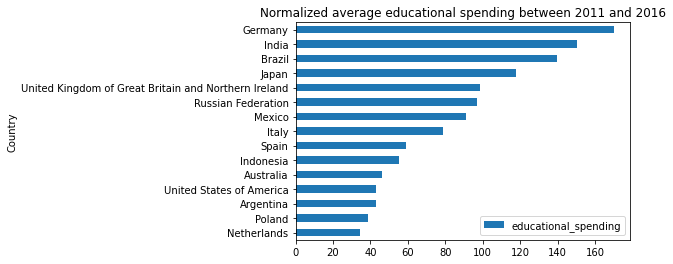

In [ ]:
x = exp.query('2011 <= TIME <= 2016')
x = x[['educational_spending','Country','TIME']]
x.educational_spending = x.educational_spending/x.groupby(['TIME'])['educational_spending'].transform('mean')
x.drop(['TIME'], axis=1, inplace=True)
x.educational_spending = x.groupby(['Country'])['educational_spending'].transform('sum')
x = x.drop_duplicates(subset=['Country'], keep='last').dropna(subset=['Country'])
x = x.set_index('Country')
x.sort_values(by='educational_spending', ascending=False)[:15][::-1].plot(kind='barh', title='Normalized average educational spending between 2011 and 2016')

In [ ]:
df=times_preprocess('data/timesData.csv')
n_usa_top_100=times_nation_top_100(df,'United States of America',2011,2016)
n_germany_top_100=times_nation_top_100(df,'Germany',2011,2016)
ucsd_rankings=times_univ_ranking_list(df,'University of California, San Diego')
ucsd_details=times_univ_dataframe(df,'University of California, San Diego')

   world_rank                        university_name  \
0           1                     Harvard University   
1           2     California Institute of Technology   
2           3  Massachusetts Institute of Technology   
3           4                    Stanford University   
4           5                   Princeton University   

                    country  teaching international  research  citations  \
0  United States of America      99.7          72.4      98.7       98.8   
1  United States of America      97.7          54.6      98.0       99.9   
2  United States of America      97.8          82.3      91.4       99.9   
3  United States of America      98.3          29.5      98.1       99.2   
4  United States of America      90.9          70.3      95.4       99.9   

   income total_score num_students  student_staff_ratio  \
0    34.5        96.1       20,152                  8.9   
1    83.7        96.0        2,243                  6.9   
2    87.5        95.6       1

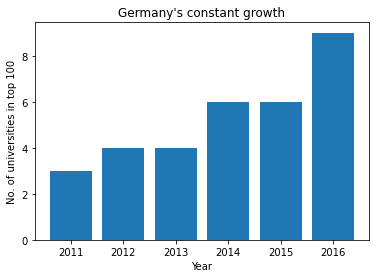

In [ ]:
years=[2011,2012,2013,2014,2015,2016]
plt.figure()
plt.bar(years,n_germany_top_100)
plt.xlabel('Year')
plt.ylabel('No. of universities in top 100')
plt.title('Germany\'s constant growth')
plt.show()

**We noticed previously that Germany had the highest average educational spending between 2011 and 2016. As a fruit of their investment, we also notice that the number of German Universities in the top 100 has constantly increased over the years, which is a really positive sign for Germany.This motivates us to check the relationship between spending on education by various countries and its effect on rankings.**

### RELATIONSHIP BETWEEN SPENDING AND RANKING ###

#### CWUR Rankings ####

In [ ]:
country_map = {'Russian Federation':'Russia','United Kingdom of Great Britain and Northern Ireland': 'United Kingdom'}
exp.Country = exp.Country.map(lambda c: country_map[c] if c in country_map.keys() else c)
countries_list = exp[exp['educational_spending']>150000]['Country'].unique()
countries_list = countries_list[countries_list != 'United States of America']
x_spending = exp[['TIME', 'Country', 'educational_spending']]
x_spending = x_spending.rename(columns= {"Country":"country","TIME":"year"})
x_spending = x_spending.query('country in @countries_list')
x_spending['expenditure'] = x_spending.groupby(['year','country'])['educational_spending'].transform('sum')
x_spending = x_spending.drop_duplicates(subset=['year','country'])

In [ ]:
# get cwur ranking for the last 10 years
ranking_cwur = pd.read_csv('data/cwurData.csv')
columns = ['world_rank', 'institution', 'country', 'national_rank', 'score', 'year']
ranking_cwur.head()
years = [2016,2017,2018,2019,2020,2021]
for year in years:
    ranking_cwur = pd.concat([ranking_cwur, scrape_data.scrape_cwur(year, columns)])

In [ ]:
# get cwur rankings for last 10 years for countries in countries list
x = ranking_cwur[['world_rank','country','year']].dropna()
x.world_rank = x.world_rank.astype('str')
x.world_rank = x.world_rank.str.split('T').str[0]
x.world_rank = x.world_rank.astype('int')
x = x.query('country in @countries_list')
x = x[x['world_rank'] < 500]
x['count'] = x.groupby(['year','country'])['world_rank'].transform('count')
x.drop_duplicates(subset=['year','country'], inplace = True)
x = x.query('year >= 2014')

In [ ]:
selection = alt.selection_multi(fields=['country'], bind='legend')
chart1 = alt.Chart(x,  title="Rankings over time").mark_line().encode(
    x=alt.X('year:N', axis=alt.Axis(tickMinStep = 0.5, labelAngle=0)),
    y=alt.Y('count', title='rankings'),
    color='country:N',
    opacity=alt.condition(selection, alt.value(1), alt.value(0.2))
).add_selection(
    selection
).properties(
    width=400,
    height=300
)


chart2 = alt.Chart(x_spending, title="Expenditure over time").mark_line().encode(
    x=alt.X('year:N', axis=alt.Axis(tickMinStep = 0.5, labelAngle=0)),
    y='expenditure',
    color='country:N',
    opacity=alt.condition(selection, alt.value(1), alt.value(0.2))
).add_selection(
    selection
).properties(
    width=400,
    height=300
)
alt.hconcat(chart1, chart2).configure_axis(
    grid=False)

alt.HConcatChart(...)

#### There seems to be some trends especially in the cases of Japan, where both have decreased and Germany and Brazil, where both values have increased slightly. Values have remained constant for other countries except India which hasn't performed well in rankings despite increased spending. However no clear correlation can be established ####

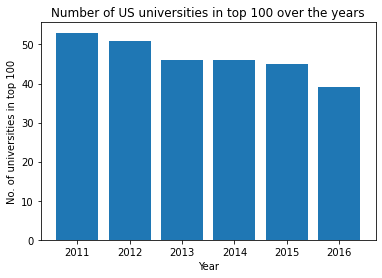

In [ ]:
plt.figure()
years=[2011,2012,2013,2014,2015,2016]
plt.bar(years,n_usa_top_100)
plt.xlabel('Year')
plt.ylabel('No. of universities in top 100')
plt.title('Number of US universities in top 100 over the years')
plt.show()

**Now let's analyze the performance of UCSD specifically**

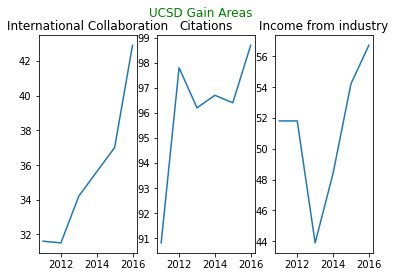

In [ ]:
years=[2011,2012,2013,2014,2015,2016]
plt.figure()
plt.subplot(1,3,1)
plt.plot(years,list(ucsd_details['international'].astype(float)))
plt.title('International Collaboration')
plt.subplot(1,3,2)
plt.plot(years,list(ucsd_details['citations']))
plt.title('Citations')
plt.subplot(1,3,3)
plt.plot(years,list(ucsd_details['income'].astype(float)))
plt.title('Income from industry')
suptitle_obj=plt.suptitle('UCSD Gain Areas')
plt.setp(suptitle_obj,color='g')
plt.show()

**UCSD has made tremendous improvements in the areas of international collaboration, citations and industrial income over the years.**

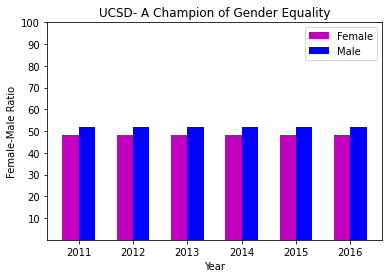

In [ ]:
index=np.arange(2011,2017)
bar_width=0.3
fig, ax = plt.subplots()
female = ax.bar(index,ucsd_details['female_male_ratio'].str.split(":").str[0].astype(int) , bar_width,color='m',
                label="Female")

male = ax.bar(index+bar_width,ucsd_details['female_male_ratio'].str.split(":").str[1].astype(int),
                 bar_width, color='b',label="Male")

ax.set_xlabel('Year')
ax.set_ylabel('Female-Male Ratio')
ax.set_title('UCSD- A Champion of Gender Equality')
ax.set_yticks([10,20,30,40,50,60,70,80,90,100])
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(index)
ax.legend()
plt.show()

**UCSD has constantly had equal representation of females and males among its student population, which is a very healthy sign for an educational environment.**

**ARWU(Shanghai) Ranking**

In [ ]:
##here is data for shanghai

df_sh = pd.read_csv('data/shanghaiData.csv')
df_sh = df_sh.fillna(value=0, axis=None, inplace=False, limit=None, downcast=None)
df_sh.world_rank = df_sh.world_rank.str.split("-").str[0]
df_sh.head()


,world_rank,university_name,national_rank,total_score,alumni,award,hici,ns,pub,pcp,year
0,1,Harvard University,1,100.0,100.0,100.0,100.0,100.0,100.0,72.4,2005
1,2,University of Cambridge,1,73.6,99.8,93.4,53.3,56.6,70.9,66.9,2005
2,3,Stanford University,2,73.4,41.1,72.2,88.5,70.9,72.3,65.0,2005
3,4,"University of California, Berkeley",3,72.8,71.8,76.0,69.4,73.9,72.2,52.7,2005
4,5,Massachusetts Institute of Technology (MIT),4,70.1,74.0,80.6,66.7,65.8,64.3,53.0,2005


In [ ]:
##Add countries to the dataset
uni_country = pd.read_csv('data/school_and_country_table.csv')
uni_country = uni_country.rename(columns={'school_name':'university_name'})
uni_country.head()

,university_name,country
0,Harvard University,United States of America
1,California Institute of Technology,United States of America
2,Massachusetts Institute of Technology,United States of America
3,Stanford University,United States of America
4,Princeton University,United States of America


In [ ]:
df_sh = pd.merge(df_sh, uni_country, on='university_name', how='left')
df_sh.head()


,world_rank,university_name,national_rank,total_score,alumni,award,hici,ns,pub,pcp,year,country
0,1,Harvard University,1,100.0,100.0,100.0,100.0,100.0,100.0,72.4,2005,United States of America
1,2,University of Cambridge,1,73.6,99.8,93.4,53.3,56.6,70.9,66.9,2005,United Kingdom
2,3,Stanford University,2,73.4,41.1,72.2,88.5,70.9,72.3,65.0,2005,United States of America
3,4,"University of California, Berkeley",3,72.8,71.8,76.0,69.4,73.9,72.2,52.7,2005,United States of America
4,5,Massachusetts Institute of Technology (MIT),4,70.1,74.0,80.6,66.7,65.8,64.3,53.0,2005,NaN


In [ ]:
df_sh['country'].replace(['United States of America'],'United States',inplace=True)
df_sh['country'].replace(['Taiwan'],'China',inplace=True)
df_sh['country'].replace(['Hong Kong'],'China',inplace=True)
df_sh_sh=df_sh
df_sh.head()

,world_rank,university_name,national_rank,total_score,alumni,award,hici,ns,pub,pcp,year,country
0,1,Harvard University,1,100.0,100.0,100.0,100.0,100.0,100.0,72.4,2005,United States
1,2,University of Cambridge,1,73.6,99.8,93.4,53.3,56.6,70.9,66.9,2005,United Kingdom
2,3,Stanford University,2,73.4,41.1,72.2,88.5,70.9,72.3,65.0,2005,United States
3,4,"University of California, Berkeley",3,72.8,71.8,76.0,69.4,73.9,72.2,52.7,2005,United States
4,5,Massachusetts Institute of Technology (MIT),4,70.1,74.0,80.6,66.7,65.8,64.3,53.0,2005,NaN


In [ ]:
df_sh1 = df_sh.iloc[:500,:]
df_sh2 = df_sh.iloc[500:1000,:]
df_sh3 = df_sh.iloc[1000:1510,:]
df_sh4 = df_sh.iloc[1510:2013,:]
df_sh5 = df_sh.iloc[2013:2514,:]
df_sh6 = df_sh.iloc[2514:3014,:]
df_sh7 = df_sh.iloc[3014:3514,:]
df_sh8 = df_sh.iloc[3514:3798,:]
df_sh9 = df_sh.iloc[3798:3897,:]
df_sh10 = df_sh.iloc[3897:4397,:]
df_sh11 = df_sh.iloc[4397:,:]
print("Shape of new dataframes - {} , {}, {} , {} , {} , {} , {} , {} , {} , {} , {}".format(df_sh1.shape, df_sh2.shape,df_sh3.shape,df_sh4.shape,df_sh5.shape,df_sh6.shape,df_sh7.shape,df_sh8.shape,df_sh9.shape,df_sh10.shape,df_sh11.shape))

**After spliting dara into 11 pieces, notice world_rank column is not well-defined like "351-400", then change the values to their actual ranking.**

In [ ]:
for i in range(0,len(df_sh1)):
    df_sh1.loc[i,"world_rank"] = int(i+1)
for i in range(500,500+len(df_sh2)):
    df_sh2.loc[i,"world_rank"] = int(i-499)
for i in range(1000,1000+len(df_sh3)):
    df_sh3.loc[i,"world_rank"] = int(i-999)
for i in range(1510,1510+len(df_sh4)):
    df_sh4.loc[i,"world_rank"] = int(i-1509)
for i in range(2013,2013+len(df_sh5)):
    df_sh5.loc[i,"world_rank"] = int(i-2012)
for i in range(2514,2514+len(df_sh6)):
    df_sh6.loc[i,"world_rank"] = int(i-2513)
for i in range(3014,3014+len(df_sh7)):
    df_sh7.loc[i,"world_rank"] = int(i-3013)
for i in range(3514,3514+len(df_sh8)):
    df_sh8.loc[i,"world_rank"] = int(i-3513)
for i in range(3798,3798+len(df_sh9)):
    df_sh9.loc[i,"world_rank"] = int(i-3797)
for i in range(3897,3897+len(df_sh10)):
    df_sh10.loc[i,"world_rank"] = int(i-3896)
for i in range(4397,4397+len(df_sh11)):
    df_sh11.loc[i,"world_rank"] = int(i-4396)

**Looking for the universities in top 500 and the countries they belong**

In [ ]:
tool_js = """
<div style="border-bottom: 1px solid rgba(255,255,255,.3); font-size: 18px;padding-bottom: 7px;margin-bottom: 7px">
                 {} 
                 </div>
                 world_rank：{} <br>
                 national_rank：{} <br>
                 total_score：{} <br>
                 alumni：{} <br>
                 award：{} <br>
                 hici：{} <br>
                 ns：{} <br>
                 pup：{} <br>
                 pcp：{} <br>
                 year: {} <br>
                 country: {} <br>
                 
"""
df_sh15 = df_sh11[df_sh11['world_rank'] <= 100]
df_sh15 = df_sh15.sort_values(by="total_score" , ascending=True)

university, score = [], []
for idx, row in df_sh15.iterrows():
    tjs = tool_js.format(row['university_name'], row['world_rank'], row['national_rank'],row['total_score'], 
                         row['alumni'],row['award'], row['hici'],row['ns'],row['pub'], row['pcp'], row['year'], row['country']) 

    university.append(re.sub('（.*?）', '',row['university_name']))
    score.append(opts.BarItem(name='', value=row['total_score'], tooltip_opts=opts.TooltipOpts(formatter=tjs)))
df_sh15


,world_rank,university_name,national_rank,total_score,alumni,award,hici,ns,pub,pcp,year,country
4496,100,Texas A&M University,51,23.9,0.0,0.0,34.3,22.7,49.5,20.9,2015,United States
4495,99,Michigan State University,50,24.0,8.9,0.0,30.7,21.8,50.6,18.9,2015,United States
4494,98,VU University Amsterdam,4,24.2,0.0,0.0,27.8,18.0,55.5,33.3,2015,Netherlands
4493,97,University of Bonn,4,24.3,15.4,19.8,17.4,21.1,39.8,25.9,2015,Germany
4492,96,McMaster University,4,24.4,12.6,18.8,23.2,15.1,44.5,22.5,2015,Canada
...,...,...,...,...,...,...,...,...,...,...,...,...
4401,5,University of Cambridge,1,68.8,77.1,96.6,50.8,55.6,66.4,55.8,2015,United Kingdom
4400,4,"University of California, Berkeley",4,69.6,65.1,79.4,66.1,65.6,67.9,56.5,2015,United States
4399,3,Massachusetts Institute of Technology (MIT),3,70.4,68.2,80.7,60.6,73.1,61.1,68.0,2015,NaN
4398,2,Stanford University,2,73.3,40.7,89.6,80.1,70.1,70.6,53.8,2015,United States


In [ ]:
bar = (Bar()
       .add_xaxis(university)
       .add_yaxis('', score, category_gap='30%')
       .set_global_opts(title_opts=opts.TitleOpts(title="2015 TOP 100",
                                                  pos_left="center",
                                                  title_textstyle_opts=opts.TextStyleOpts(font_size=20)),
                        datazoom_opts=opts.DataZoomOpts(range_start=70, range_end=100, orient='vertical'),
                        visualmap_opts=opts.VisualMapOpts(is_show=False, max_=100, min_=60, dimension=0,
                                range_color=['#00FFFF', '#FF7F50']),
                        legend_opts=opts.LegendOpts(is_show=False),
                        xaxis_opts=opts.AxisOpts(is_show=False, is_scale=True),
                        yaxis_opts=opts.AxisOpts(axistick_opts=opts.AxisTickOpts(is_show=False),
                                                 axisline_opts=opts.AxisLineOpts(is_show=False),
                                                 axislabel_opts=opts.LabelOpts(font_size=12)))
       .set_series_opts(label_opts=opts.LabelOpts(is_show=True,
                                                  position='right',
                                                  font_style='italic'),
                        itemstyle_opts={"normal": {
                                                    "barBorderRadius": [30, 30, 30, 30],
                                                    'shadowBlur': 10,
                                                    'shadowColor': 'rgba(120, 36, 50, 0.5)',
                                                    'shadowOffsetY': 5,
                                                }
                                       }
).reversal_axis())

grid = (
        Grid(init_opts=opts.InitOpts(theme='purple-passion', width='1000px', height='1200px'))
        .add(bar, grid_opts=opts.GridOpts(pos_right='10%', pos_left='20%'))
    )
grid.render_notebook()

In [ ]:
t_data = df_sh11[df_sh11['world_rank']<=100]
t_data = t_data.groupby(['country'])['university_name'].count().reset_index()
t_data.columns = ['country', 'num']
t_data = t_data.sort_values(by="num" , ascending=False) 


bar = (Bar(init_opts=opts.InitOpts(theme='purple-passion', width='1000px', height='1000px'))
       .add_xaxis(t_data['country'].tolist())
       .add_yaxis('num', t_data['num'].tolist(), category_gap='50%')
       .reversal_axis()
       .set_global_opts(title_opts=opts.TitleOpts(title="2015 TOP 100 Universities grouped by Countries",
                                                  pos_left="center",
                                                  title_textstyle_opts=opts.TextStyleOpts(font_size=20)),
                        visualmap_opts=opts.VisualMapOpts(is_show=False, max_=300, min_=0, dimension=1,
                                range_color=['#00FFFF', '#FF7F50']),
                        legend_opts=opts.LegendOpts(is_show=False),
                        
                        xaxis_opts=opts.AxisOpts(
                            name = 'Country',
                            name_location = 'start',
        
            
                            name_gap = 5,
                            is_show=True,
                            position='left',
                                                 axistick_opts=opts.AxisTickOpts(is_show=True),
                                                 axisline_opts=opts.AxisLineOpts(is_show=True),
                                                 axislabel_opts=opts.LabelOpts(font_size=15)),
                            yaxis_opts=opts.AxisOpts(is_show=True))
       .set_series_opts(label_opts=opts.LabelOpts(is_show=True,
                                                  position='right',
                                                  font_size=15,
                                                  font_style='italic'),
                        itemstyle_opts={"normal": {
                                                    "barBorderRadius": [30, 30, 30, 30],
                                                    'shadowBlur': 10,
                                                    'shadowColor': 'rgba(120, 36, 50, 0.5)',
                                                    'shadowOffsetY': 5,
                                                }
                                       }
))

bar.render_notebook()

**Comparison between universities in USA, China and UK**

In [ ]:
cn_data_x, cn_data_y = [], []
for idx, row in df_sh11[(df_sh11.country=='China')].iterrows():
    cn_data_y.append([row['alumni'], row['pcp'], row['world_rank'], row['university_name']])
    cn_data_x.append(row['hici'])
    
un_data_x, un_data_y = [], []
for idx, row in df_sh11[(df_sh11.country=='United States')].iterrows():
    un_data_y.append([row['alumni'], row['pcp'], row['world_rank'], row['university_name']])
    un_data_x.append(row['hici'])
    
uk_data_x, uk_data_y = [], []
for idx, row in df_sh11[(df_sh11.country=='United Kingdom')].iterrows():
    uk_data_y.append([row['alumni'], row['pcp'], row['world_rank'], row['university_name']])
    uk_data_x.append(row['hici'])
tool_js = """
function (obj) {
            var value = obj.value;
            var schema = [{name: 'rank', index: 0, text: 'rank'},
                            {name: 'pcp', index: 1, text: 'pcp'},
                            {name: 'alumni', index: 2, text: 'alumni'},
                            {name: 'hici', index: 3, text: 'hici'}];
            return '<div style="border-bottom: 1px solid rgba(255,255,255,.3); font-size: 18px;padding-bottom: 7px;margin-bottom: 7px">'
                + value[4] 
                + '</div>'
                + schema[0].text + '：' + value[3] + '<br>'
                + schema[1].text + '：' + value[2] + '<br>'
                + schema[2].text + '：' + value[1] + '<br>'
                + schema[3].text + '：' + value[0] + '<br>';
        }
"""

itemStyle_1 = {
    'opacity': 0.8,
    'shadowBlur': 10,
    'shadowOffsetX': 0,
    'shadowOffsetY': 0,
    'shadowColor': 'rgba(0, 0, 0, 0.5)',
    'color': '#80F1BE'
}

itemStyle_2 = {
    'opacity': 0.8,
    'shadowBlur': 10,
    'shadowOffsetX': 0,
    'shadowOffsetY': 0,
    'shadowColor': 'rgba(0, 0, 0, 0.5)',
    'color': '#fec42c'
}

itemStyle_3 = {
    'opacity': 0.8,
    'shadowBlur': 10,
    'shadowOffsetX': 0,
    'shadowOffsetY': 0,
    'shadowColor': 'rgba(0, 0, 0, 0.5)',
    'color': '#dd4444'
}


visualMap = [
        {
            'left': 'right',
            'top': '10%',
            'dimension': 2,
            'min': 20,
            'max': 100,
            'itemWidth': 30,
            'itemHeight': 120,
            'calculable': True,
            'precision': 0.1,
            'text': ['area of circle：PCP'],
            'textGap': 30,
            'textStyle': {
                'color': '#fff'
            },
            'inRange': {
                'symbolSize': [10, 50]
            },
            'outOfRange': {
                'symbolSize': [10, 50],
                'color': ['rgba(255,255,255,.2)']
            },
            'controller': {
                'inRange': {
                    'color': ['#c23531']
                },
                'outOfRange': {
                    'color': ['#444']
                }
            }
        },
        {
            'left': 'right',
            'bottom': '15%',
            'dimension': 3,
            'min': 1,
            'max': 500,
            'itemHeight': 120,

            'precision': 0.1,
            'text': ['intensity：rank'],
            'textGap': 30,
            'textStyle': {
                'color': '#fff'
            },
            'inRange': {
                'colorLightness': [0.5, 1]
            },
            'outOfRange': {
                'color': ['rgba(255,255,255,.2)']
            },
            'controller': {
                'inRange': {
                    'color': ['#c23531']
                },
                'outOfRange': {
                    'color': ['#444']
                }
            }
        }
    ]

scatter1 = (Scatter(init_opts=opts.InitOpts(bg_color='#404a59',width='1200px', height='800px'))
            .add_xaxis(cn_data_x)
            .add_yaxis("China", cn_data_y,
                       label_opts=opts.LabelOpts(is_show=False),
                       itemstyle_opts=itemStyle_3
                       )
            .set_global_opts(yaxis_opts=opts.AxisOpts(name='alumni', type_="value", is_scale=True, 
                                                      name_textstyle_opts={'color': '#fff', 'fontSize': 16},
                                                      axisline_opts=opts.AxisLineOpts(linestyle_opts=opts.LineStyleOpts(color='#eee'))),
                             xaxis_opts=opts.AxisOpts(name='HiCi', type_="value", is_scale=True, 
                                                      name_textstyle_opts={'color': '#fff', 'fontSize': 16},
                                                      axisline_opts=opts.AxisLineOpts(linestyle_opts=opts.LineStyleOpts(color='#eee'))),
                             tooltip_opts=opts.TooltipOpts(is_show=True, background_color='#222', border_color='#777', border_width=1, formatter=JsCode(tool_js)),
                             legend_opts=opts.LegendOpts(is_show=True, pos_right=10,
                                                         textstyle_opts=opts.TextStyleOpts(color='#fff',font_size=16)),
                             visualmap_opts=visualMap
                             )
            )

scatter2 = (Scatter(init_opts=opts.InitOpts(bg_color='#404a59',width='1200px', height='800px'))
            .add_xaxis(un_data_x)
            .add_yaxis("US", un_data_y,
                       label_opts=opts.LabelOpts(is_show=False),
                       itemstyle_opts=itemStyle_2
                       )
            )
            
scatter3 = (Scatter(init_opts=opts.InitOpts(bg_color='#404a59',width='1200px', height='800px'))
            .add_xaxis(uk_data_x)
            .add_yaxis("UK", uk_data_y,
                       label_opts=opts.LabelOpts(is_show=False),
                       itemstyle_opts=itemStyle_1
                       )
            )
            
scatter1.overlap(scatter2)
scatter1.overlap(scatter3)
scatter1.render_notebook()

In [ ]:
t_data = df_sh11[(df_sh11['country'] == 'China') & (df_sh11['world_rank'] <= 200)]

data_cn = []
for idx, row in t_data.iterrows():
    data_cn.append([row['alumni'], row['award'], row['hici'],
                    row['ns'], row['pub'], row['pcp'], row['university_name']])


t_data =df_sh11[(df_sh11['country']  == 'United States') & (df_sh11['world_rank'] <= 200)]

data_un = []
for idx, row in t_data.iterrows():
    data_un.append([row['alumni'], row['award'], row['hici'],
                    row['ns'], row['pub'], row['pcp'], row['university_name']])
                    
t_data = df_sh11[(df_sh11['country'] == 'United Kingdom') & (df_sh11['world_rank'] <= 200)]

data_uk = []
for idx, row in t_data.iterrows():
    data_uk.append([row['alumni'], row['award'], row['hici'],
                    row['ns'], row['pub'], row['pcp'], row['university_name']])



In [ ]:
split_line_style = {'color': [
                    'rgba(238, 197, 102, 0.1)', 'rgba(238, 197, 102, 0.2)',
                     
                    'rgba(238, 197, 102, 0.8)', 'rgba(238, 197, 102, 1)',
                    'rgba(238, 197, 102, 0.4)', 'rgba(238, 197, 102, 0.6)'
                    ][::-1]
}

tool_js = """
function (obj) {
            var value = obj.value;
            var schema = [{name: 'alumni', index: 1, text: 'alumni'},
                            {name: 'award', index: 2, text: 'award'},
                            {name:  'hici', index: 3, text: 'hici'},
                            {name: 'ns', index: 3, text: 'n&s'},
                            {name:  'pub', index: 2, text: 'pub'},
                            {name: 'pcp', index: 3, text: 'pcp'}];
            return '<div style="border-bottom: 1px solid rgba(255,255,255,.3); font-size: 18px;padding-bottom: 7px;margin-bottom: 7px">'
                + value[6] 
                + '</div>'
                + schema[0].text + '：' + value[0] + '<br>'
                + schema[1].text + '：' + value[1] + '<br>'
                + schema[2].text + '：' + value[2] + '<br>'
                + schema[3].text + '：' + value[3] + '<br>'
                + schema[4].text + '：' + value[4] + '<br>'
                + schema[5].text + '：' + value[5] + '<br>';
        }
"""

radar = Radar(init_opts=opts.InitOpts(theme='dark', bg_color='#161627', height='800px', width='1000px'))
radar.add_schema(shape='circle',
                 textstyle_opts=opts.TextStyleOpts(color='rgb(238, 197, 102)'),
                 axisline_opt=opts.LineStyleOpts(is_show=True, color='rgba(238, 197, 102, 1)'),
                 splitline_opt=opts.SplitLineOpts(is_show=True, linestyle_opts=split_line_style),
                 schema=[opts.RadarIndicatorItem(name='alumni', max_=100),
                         opts.RadarIndicatorItem(name='award', max_=100),
                         opts.RadarIndicatorItem(name='hici', max_=100),
                         opts.RadarIndicatorItem(name="n&s", max_=100),
                         opts.RadarIndicatorItem(name="pub", max_=100),
                         opts.RadarIndicatorItem(name="pcp", max_=100)])


radar.add('China', data_cn, symbol='none', is_selected=False,
          label_opts=opts.LabelOpts(is_show=False),
          linestyle_opts=opts.LineStyleOpts(color='#dd4444', width=1, opacity=0.5),
          areastyle_opts=opts.AreaStyleOpts(color='#dd4444', opacity=0.05))

radar.add('US', data_un, symbol='none', is_selected=True,
          label_opts=opts.LabelOpts(is_show=False),
          linestyle_opts=opts.LineStyleOpts(color='#80F1BE', width=1, opacity=0.5),
          areastyle_opts=opts.AreaStyleOpts(color='#80F1BE', opacity=0.05))

radar.add('UK', data_uk, symbol='none', is_selected=False,
          label_opts=opts.LabelOpts(is_show=False),
          linestyle_opts=opts.LineStyleOpts(color='#fec42c', width=1, opacity=0.5),
          areastyle_opts=opts.AreaStyleOpts(color='#fec42c',opacity=0.05))

radar.set_global_opts(legend_opts=opts.LegendOpts(is_show=True, selected_mode='multiple', pos_bottom=5),
                      tooltip_opts=opts.TooltipOpts(is_show=True, background_color='#222', 
                          border_color='#777', border_width=1, formatter=JsCode(tool_js)),
                      title_opts=opts.TitleOpts(title="Comparison of TOP200 Universities in US&China&UK in 2015", pos_left='center',
                                                title_textstyle_opts=opts.TextStyleOpts(font_size=20)))

radar.render("radar_chart.html")
radar.render_notebook() 

**Comparison between Top 100 universities in different ranking**

In [ ]:
page = Page(layout=Page.SimplePageLayout) 
l_cn,l_us,l_uk,l_ga,l_it,l_jp,l_ca,l_au,l_ntl,l_swe=[],[],[],[],[],[],[],[],[],[]
for i in range(2012,2016):
    t_data =df_sh[(df_sh['country']=='United States')&(df_sh['year']==i)&(df_sh['world_rank']<=100)]
    l_us.append(len(t_data))
for i in range(2012,2016):
    t_data =df_sh[(df_sh['country']=='China')&(df_sh['year']==i)&(df_sh['world_rank']<=100)]
    l_cn.append(len(t_data))
for i in range(2012,2016):
    t_data =df_sh[(df_sh['country']=='United Kingdom')&(df_sh['year']==i)&(df_sh['world_rank']<=100)]
    l_uk.append(len(t_data))
for i in range(2012,2016):
    t_data =df_sh[(df_sh['country']=='Germany')&(df_sh['year']==i)&(df_sh['world_rank']<=100)]
    l_ga.append(len(t_data))
for i in range(2012,2016):
    t_data =df_sh[(df_sh['country']=='Italy')&(df_sh['year']==i)&(df_sh['world_rank']<=100)]
    l_it.append(len(t_data))
for i in range(2012,2016):
    t_data =df_sh[(df_sh['country']=='Japan')&(df_sh['year']==i)&(df_sh['world_rank']<=100)]
    l_jp.append(len(t_data))
for i in range(2012,2016):
    t_data =df_sh[(df_sh['country']=='Canada')&(df_sh['year']==i)&(df_sh['world_rank']<=100)]
    l_ca.append(len(t_data))
for i in range(2012,2016):
    t_data =df_sh[(df_sh['country']=='Australia')&(df_sh['year']==i)&(df_sh['world_rank']<=100)]
    l_au.append(len(t_data))
for i in range(2012,2016):
    t_data =df_sh[(df_sh['country']=='Netherlands')&(df_sh['year']==i)&(df_sh['world_rank']<=100)]
    l_ntl.append(len(t_data))   
for i in range(2012,2016):
    t_data =df_sh[(df_sh['country']=='Sweden')&(df_sh['year']==i)&(df_sh['world_rank']<=100)]
    l_swe.append(len(t_data))
# time = ["2005","2006","2007","2008","2009","2010","2011","2012","2013","2014","2015"]
time = ["2012","2013","2014","2015"]
l1 = (
    Line(init_opts=opts.InitOpts(theme=ThemeType.MACARONS))
    .set_global_opts(
        tooltip_opts=opts.TooltipOpts(is_show=False),
        xaxis_opts=opts.AxisOpts(type_="category"),
        yaxis_opts=opts.AxisOpts(
            type_="value",
            axistick_opts=opts.AxisTickOpts(is_show=True),
            splitline_opts=opts.SplitLineOpts(is_show=True),
        ),
    )
    .add_xaxis(xaxis_data=time)
    .add_yaxis(
        series_name="United States",
        is_selected=True,
        y_axis=l_us,
        symbol="emptyCircle",
        is_symbol_show=True,
        label_opts=opts.LabelOpts(is_show=False),
#         markline_opts=opts.MarkLineOpts(
#                    data=[opts.MarkLineItem(type_="average", name="平均值")]    #可以画平均线，很有用处。
#                )
    )
    .add_yaxis(
        series_name="United Kingdom",
        is_selected=False,
        y_axis=l_uk,
        symbol="emptyCircle",
        is_symbol_show=True,
        label_opts=opts.LabelOpts(is_show=False),
)
    .add_yaxis(
        series_name="China",
        y_axis=l_cn,
        is_selected=False,
        symbol="emptyCircle",
        is_symbol_show=True,
        label_opts=opts.LabelOpts(is_show=False),
)
    .add_yaxis(
        series_name="Germany",
        y_axis=l_ga,
        is_selected=False,
        symbol="emptyCircle",
        is_symbol_show=True,
        label_opts=opts.LabelOpts(is_show=False),
)
    .add_yaxis(
        series_name="Italy",
        y_axis=l_it,
        symbol="emptyCircle",
        is_selected=False,
        is_symbol_show=True,
        label_opts=opts.LabelOpts(is_show=False),
)
    .add_yaxis(
        series_name="Canada",
        y_axis=l_ca,
        is_selected=False,
        symbol="emptyCircle",
        is_symbol_show=True,
        label_opts=opts.LabelOpts(is_show=False),
)
    .add_yaxis(
        series_name="Japan",
        y_axis=l_jp,
        is_selected=False,
        symbol="emptyCircle",
        is_symbol_show=True,
        label_opts=opts.LabelOpts(is_show=False),
)
    .add_yaxis(
        series_name="Australia",
        y_axis=l_au,
        is_selected=False,
        symbol="emptyCircle",
        is_symbol_show=True,
        label_opts=opts.LabelOpts(is_show=False),
   
)
    .add_yaxis(
        series_name="Netherlands",
        y_axis=l_ntl,
        is_selected=False,
        symbol="emptyCircle",
        is_symbol_show=True,
        label_opts=opts.LabelOpts(is_show=False),
   
)
    .add_yaxis(
        series_name="Sweden",
        y_axis=l_swe,
        is_selected=False,
        symbol="emptyCircle",
        is_symbol_show=True,
        label_opts=opts.LabelOpts(is_show=False),
   
)
    
     .set_global_opts(title_opts=opts.TitleOpts(title="ARWU:TOP 100 Universities Over Years" ,
                                                pos_left="center",
                                                title_textstyle_opts=opts.TextStyleOpts(font_size=20)),
                        legend_opts=opts.LegendOpts(type_="scroll", pos_left="right", orient="vertical"))
                     
)
page.add(l1)

In [ ]:
df_sh= pd.read_csv('data/timesData.csv')
df_sh['world_rank']=df_sh['world_rank'].str.split("-").str[0]
df_sh['world_rank'] = df_sh['world_rank'].map(lambda x: x.lstrip('='))
df_sh['world_rank']= df_sh['world_rank'].astype('int')

l_cn,l_us,l_uk,l_ga,l_it,l_jp,l_ca,l_au,l_ntl,l_swe=[],[],[],[],[],[],[],[],[],[]
for i in range(2012,2016):
    t_data =df_sh[(df_sh['country']=='United States of America')&(df_sh['year']==i)&(df_sh['world_rank']<=100)]
    l_us.append(len(t_data))
for i in range(2012,2016):
    t_data =df_sh[(df_sh['country']=='China')&(df_sh['year']==i)&(df_sh['world_rank']<=100)]
    l_cn.append(len(t_data))
for i in range(2012,2016):
    t_data =df_sh[(df_sh['country']=='United Kingdom')&(df_sh['year']==i)&(df_sh['world_rank']<=100)]
    l_uk.append(len(t_data))
for i in range(2012,2016):
    t_data =df_sh[(df_sh['country']=='Germany')&(df_sh['year']==i)&(df_sh['world_rank']<=100)]
    l_ga.append(len(t_data))
for i in range(2012,2016):
    t_data =df_sh[(df_sh['country']=='Italy')&(df_sh['year']==i)&(df_sh['world_rank']<=100)]
    l_it.append(len(t_data))
for i in range(2012,2016):
    t_data =df_sh[(df_sh['country']=='Japan')&(df_sh['year']==i)&(df_sh['world_rank']<=100)]
    l_jp.append(len(t_data))
for i in range(2012,2016):
    t_data =df_sh[(df_sh['country']=='Canada')&(df_sh['year']==i)&(df_sh['world_rank']<=100)]
    l_ca.append(len(t_data))
for i in range(2012,2016):
    t_data =df_sh[(df_sh['country']=='Australia')&(df_sh['year']==i)&(df_sh['world_rank']<=100)]
    l_au.append(len(t_data))
for i in range(2012,2016):
    t_data =df_sh[(df_sh['country']=='Netherlands')&(df_sh['year']==i)&(df_sh['world_rank']<=100)]
    l_ntl.append(len(t_data))   
for i in range(2012,2016):
    t_data =df_sh[(df_sh['country']=='Sweden')&(df_sh['year']==i)&(df_sh['world_rank']<=100)]
    l_swe.append(len(t_data))
# time = ["2005","2006","2007","2008","2009","2010","2011","2012","2013","2014","2015"]
time = ["2012","2013","2014","2015"]
l2 = (
    Line(init_opts=opts.InitOpts(theme=ThemeType.MACARONS))
    .set_global_opts(
        tooltip_opts=opts.TooltipOpts(is_show=False),
        xaxis_opts=opts.AxisOpts(type_="category"),
        yaxis_opts=opts.AxisOpts(
            type_="value",
            axistick_opts=opts.AxisTickOpts(is_show=True),
            splitline_opts=opts.SplitLineOpts(is_show=True),
        ),
    )
    .add_xaxis(xaxis_data=time)
    .add_yaxis(
        series_name="United States",
        is_selected=True,
        y_axis=l_us,
        symbol="emptyCircle",
        is_symbol_show=True,
        label_opts=opts.LabelOpts(is_show=False),
#         markline_opts=opts.MarkLineOpts(
#                    data=[opts.MarkLineItem(type_="average", name="平均值")]    #可以画平均线，很有用处。
#                )
    )
    .add_yaxis(
        series_name="United Kingdom",
        y_axis=l_uk,
        is_selected=False,
        symbol="emptyCircle",
        is_symbol_show=True,
        label_opts=opts.LabelOpts(is_show=False),
)
    .add_yaxis(
        series_name="China",
        y_axis=l_cn,
        is_selected=False,
        symbol="emptyCircle",
        is_symbol_show=True,
        label_opts=opts.LabelOpts(is_show=False),
)
    .add_yaxis(
        series_name="Germany",
        y_axis=l_ga,
        is_selected=False,
        symbol="emptyCircle",
        is_symbol_show=True,
        label_opts=opts.LabelOpts(is_show=False),
)
    .add_yaxis(
        series_name="Italy",
        y_axis=l_it,
        is_selected=False,
        symbol="emptyCircle",
        is_symbol_show=True,
        label_opts=opts.LabelOpts(is_show=False),
)
    .add_yaxis(
        series_name="Canada",
        y_axis=l_ca,
        is_selected=False,
        symbol="emptyCircle",
        is_symbol_show=True,
        label_opts=opts.LabelOpts(is_show=False),
)
    .add_yaxis(
        series_name="Japan",
        y_axis=l_jp,
        is_selected=False,
        symbol="emptyCircle",
        is_symbol_show=True,
        label_opts=opts.LabelOpts(is_show=False),
)
    .add_yaxis(
        series_name="Australia",
        y_axis=l_au,
        is_selected=False,
        symbol="emptyCircle",
        is_symbol_show=True,
        label_opts=opts.LabelOpts(is_show=False),
   
)
    .add_yaxis(
        series_name="Netherlands",
        y_axis=l_ntl,
        is_selected=False,
        symbol="emptyCircle",
        is_symbol_show=True,
        label_opts=opts.LabelOpts(is_show=False),
   
)
    .add_yaxis(
        series_name="Sweden",
        y_axis=l_swe,
        is_selected=False,
        symbol="emptyCircle",
        is_symbol_show=True,
        label_opts=opts.LabelOpts(is_show=False),
   
)
    
     .set_global_opts(title_opts=opts.TitleOpts(title="Times:TOP 100 Universities Over Years" ,
                                                pos_left="center",
                                                title_textstyle_opts=opts.TextStyleOpts(font_size=20)),
                        legend_opts=opts.LegendOpts(type_="scroll", pos_left="right", orient="vertical"))
                     
)
page.add(l2)

In [ ]:
df_sh= pd.read_csv('data/cwurData.csv')
l_cn,l_us,l_uk,l_ga,l_it,l_jp,l_ca,l_au,l_ntl,l_swe=[],[],[],[],[],[],[],[],[],[]
for i in range(2012,2016):
    t_data =df_sh[(df_sh['country']=='USA')&(df_sh['year']==i)&(df_sh['world_rank']<=100)]
    l_us.append(len(t_data))
for i in range(2012,2016):
    t_data =df_sh[(df_sh['country']=='China')&(df_sh['year']==i)&(df_sh['world_rank']<=100)]
    l_cn.append(len(t_data))
for i in range(2012,2016):
    t_data =df_sh[(df_sh['country']=='United Kingdom')&(df_sh['year']==i)&(df_sh['world_rank']<=100)]
    l_uk.append(len(t_data))
for i in range(2012,2016):
    t_data =df_sh[(df_sh['country']=='Germany')&(df_sh['year']==i)&(df_sh['world_rank']<=100)]
    l_ga.append(len(t_data))
for i in range(2012,2016):
    t_data =df_sh[(df_sh['country']=='Italy')&(df_sh['year']==i)&(df_sh['world_rank']<=100)]
    l_it.append(len(t_data))
for i in range(2012,2016):
    t_data =df_sh[(df_sh['country']=='Japan')&(df_sh['year']==i)&(df_sh['world_rank']<=100)]
    l_jp.append(len(t_data))
for i in range(2012,2016):
    t_data =df_sh[(df_sh['country']=='Canada')&(df_sh['year']==i)&(df_sh['world_rank']<=100)]
    l_ca.append(len(t_data))
for i in range(2012,2016):
    t_data =df_sh[(df_sh['country']=='Australia')&(df_sh['year']==i)&(df_sh['world_rank']<=100)]
    l_au.append(len(t_data))
for i in range(2012,2016):
    t_data =df_sh[(df_sh['country']=='Netherlands')&(df_sh['year']==i)&(df_sh['world_rank']<=100)]
    l_ntl.append(len(t_data))   
for i in range(2012,2016):
    t_data =df_sh[(df_sh['country']=='Sweden')&(df_sh['year']==i)&(df_sh['world_rank']<=100)]
    l_swe.append(len(t_data))
# time = ["2005","2006","2007","2008","2009","2010","2011","2012","2013","2014","2015"]
time = ["2012","2013","2014","2015"]
l3 = (
    Line(init_opts=opts.InitOpts(theme=ThemeType.MACARONS))
    .set_global_opts(
        tooltip_opts=opts.TooltipOpts(is_show=False),
        xaxis_opts=opts.AxisOpts(type_="category"),
        yaxis_opts=opts.AxisOpts(
            type_="value",
            axistick_opts=opts.AxisTickOpts(is_show=True),
            splitline_opts=opts.SplitLineOpts(is_show=True),
        ),
    )
    .add_xaxis(xaxis_data=time)
    .add_yaxis(
        series_name="United States",
        y_axis=l_us,

        symbol="emptyCircle",
        is_symbol_show=True,
        is_selected=True,
        label_opts=opts.LabelOpts(is_show=False),
#         markline_opts=opts.MarkLineOpts(
#                    data=[opts.MarkLineItem(type_="average", name="平均值")]    #可以画平均线，很有用处。
#                )
    )
    .add_yaxis(
        series_name="United Kingdom",
        y_axis=l_uk,
        is_selected=False,
        symbol="emptyCircle",
        is_symbol_show=True,
        label_opts=opts.LabelOpts(is_show=False),
)
    .add_yaxis(
        series_name="China",
        y_axis=l_cn,
        is_selected=False,
        symbol="emptyCircle",
        is_symbol_show=True,
        label_opts=opts.LabelOpts(is_show=False),
)
    .add_yaxis(
        series_name="Germany",
        y_axis=l_ga,
        is_selected=False,
        symbol="emptyCircle",
        is_symbol_show=True,
        label_opts=opts.LabelOpts(is_show=False),
)
    .add_yaxis(
        series_name="Italy",
        y_axis=l_it,
        is_selected=False,
        symbol="emptyCircle",
        is_symbol_show=True,
        label_opts=opts.LabelOpts(is_show=False),
)
    .add_yaxis(
        series_name="Canada",
        y_axis=l_ca,
        is_selected=False,
        symbol="emptyCircle",
        is_symbol_show=True,
        label_opts=opts.LabelOpts(is_show=False),
)
    .add_yaxis(
        series_name="Japan",
        y_axis=l_jp,
        is_selected=False,
        symbol="emptyCircle",
        is_symbol_show=True,
        label_opts=opts.LabelOpts(is_show=False),
)
    .add_yaxis(
        series_name="Australia",
        y_axis=l_au,
        is_selected=False,
        symbol="emptyCircle",
        is_symbol_show=True,
        label_opts=opts.LabelOpts(is_show=False),
   
)
    .add_yaxis(
        series_name="Netherlands",
        y_axis=l_ntl,
        is_selected=False,
        symbol="emptyCircle",
        is_symbol_show=True,
        label_opts=opts.LabelOpts(is_show=False),
   
)
    .add_yaxis(
        series_name="Sweden",
        y_axis=l_swe,
        is_selected=False,
        symbol="emptyCircle",
        is_symbol_show=True,
        label_opts=opts.LabelOpts(is_show=False),
   
)
    
     .set_global_opts(title_opts=opts.TitleOpts(title="CWUR:TOP 100 Universities Over Years" ,
                                                pos_left="center",
                                                title_textstyle_opts=opts.TextStyleOpts(font_size=20)),
                        legend_opts=opts.LegendOpts(type_="scroll", pos_left="right", orient="vertical"))
                     
)
page.add(l3)

In [ ]:
page.render_notebook()

**Study on UCSD**

In [ ]:
df_sh=df_sh_sh
t_data = df_sh[(df_sh['university_name'] == 'University of California, San Diego') & (df_sh['year']==2015)]

data_2015 = []
for idx, row in t_data.iterrows():
    data_2015.append([row['alumni'], row['award'], row['hici'],
                    row['ns'], row['pub'], row['pcp'], row['university_name']])


t_data = df_sh[(df_sh['university_name'] == 'University of California, San Diego') & (df_sh['year']==2014)]

data_2014 = []
for idx, row in t_data.iterrows():
    data_2014.append([row['alumni'], row['award'], row['hici'],
                    row['ns'], row['pub'], row['pcp'], row['university_name']])

    
t_data = df_sh[(df_sh['university_name'] == 'University of California, San Diego') & (df_sh['year']==2013)]

data_2013 = []
for idx, row in t_data.iterrows():
    data_2013.append([row['alumni'], row['award'], row['hici'],
                    row['ns'], row['pub'], row['pcp'], row['university_name']])
    
t_data = df_sh[(df_sh['university_name'] == 'University of California, San Diego') & (df_sh['year']==2012)]

data_2012 = []
for idx, row in t_data.iterrows():
    data_2012.append([row['alumni'], row['award'], row['hici'],
                    row['ns'], row['pub'], row['pcp'], row['university_name']])

In [ ]:
page1 = Page(layout=Page.SimplePageLayout)
split_line_style = {'color': [
                    'rgba(238, 197, 102, 0.1)', 'rgba(238, 197, 102, 0.2)',
                     'rgba(238, 197, 102, 0.4)', 'rgba(238, 197, 102, 0.6)',
                    'rgba(238, 197, 102, 0.8)', 'rgba(238, 197, 102, 1)'
                    
                    ][::-1]
}

tool_js = """
function (obj) {
            var value = obj.value;
            var schema = [{name: 'alumni', index: 0, text: 'alumni'},
                            {name: 'award', index: 1, text: 'award'},
                            {name:  'hici', index: 2, text: 'hici'},
                            {name: 'ns', index: 3, text: 'n&s'},
                            {name:  'pub', index: 4, text: 'pub'},
                            {name: 'pcp', index: 5, text: 'pcp'}];
            return '<div style="border-bottom: 1px solid rgba(255,255,255,.3); font-size: 18px;padding-bottom: 7px;margin-bottom: 7px">'
                + value[6] 
                + '</div>'
                + schema[0].text + '：' + value[0] + '<br>'
                + schema[1].text + '：' + value[1] + '<br>'
                + schema[2].text + '：' + value[2] + '<br>'
                + schema[3].text + '：' + value[3] + '<br>'
                + schema[4].text + '：' + value[4] + '<br>'
                + schema[5].text + '：' + value[5] + '<br>';
        }
"""

radar = Radar(init_opts=opts.InitOpts(theme='dark', bg_color='#161627', height='800px', width='1000px'))
radar.add_schema(shape='circle',
                 textstyle_opts=opts.TextStyleOpts(color='rgb(238, 197, 102)'),
                 axisline_opt=opts.LineStyleOpts(is_show=True, color='rgba(238, 197, 102, 1)'),
                 splitline_opt=opts.SplitLineOpts(is_show=True, linestyle_opts=split_line_style),
                 schema=[opts.RadarIndicatorItem(name='alumni', max_=100),
                         opts.RadarIndicatorItem(name='award', max_=100),
                         opts.RadarIndicatorItem(name='hici', max_=100),
                         opts.RadarIndicatorItem(name="n&s", max_=100),
                         opts.RadarIndicatorItem(name="pub", max_=100),
                         opts.RadarIndicatorItem(name="pcp", max_=100)])


radar.add('2015', data_2015, symbol='none', is_selected=True,
          label_opts=opts.LabelOpts(is_show=False),
          linestyle_opts=opts.LineStyleOpts(color='#dd4444', width=1, opacity=0.5),
          areastyle_opts=opts.AreaStyleOpts(color='#dd4444', opacity=0.4))

radar.add('2014', data_2014, symbol='none', is_selected=False,
          label_opts=opts.LabelOpts(is_show=False),
          linestyle_opts=opts.LineStyleOpts(color='#80F1BE', width=1, opacity=0.5),
          areastyle_opts=opts.AreaStyleOpts(color='#80F1BE', opacity=0.2))

radar.add('2013', data_2013, symbol='none', is_selected=False,
          label_opts=opts.LabelOpts(is_show=False),
          linestyle_opts=opts.LineStyleOpts(color='#fec42c', width=1, opacity=0.5),
          areastyle_opts=opts.AreaStyleOpts(color='#fec42c',opacity=0.2))

radar.add('2012', data_2012, symbol='none', is_selected=False,
          label_opts=opts.LabelOpts(is_show=False),
          linestyle_opts=opts.LineStyleOpts(color='#00E5EE', width=1, opacity=0.5),
          areastyle_opts=opts.AreaStyleOpts(color='#00E5EE',opacity=0.2))

radar.set_global_opts(legend_opts=opts.LegendOpts(is_show=True, selected_mode='multiple', pos_bottom=5),
                      tooltip_opts=opts.TooltipOpts(is_show=True, background_color='#222', 
                          border_color='#777', border_width=1, formatter=JsCode(tool_js)),
                      title_opts=opts.TitleOpts(title="UCSD performance in different domain over years", pos_left='center',
                                                title_textstyle_opts=opts.TextStyleOpts(font_size=20)))
page1.add(radar)


In [ ]:
l_ucsd=[]
for i in range(2012,2016):
    t_data =df_sh[(df_sh['university_name']=='University of California, San Diego')&(df_sh['year']==i)]
    l_ucsd.append(t_data['world_rank'].values)
l_ucsd=[15,14,14,14]

l4 = (
    Line(init_opts=opts.InitOpts(theme=ThemeType.MACARONS))
    .set_global_opts(
        tooltip_opts=opts.TooltipOpts(is_show=False),
        xaxis_opts=opts.AxisOpts(type_="category"),
        yaxis_opts=opts.AxisOpts(
            type_="value",
            axistick_opts=opts.AxisTickOpts(is_show=True),
            splitline_opts=opts.SplitLineOpts(is_show=True),
        ),
    )
    .add_xaxis(xaxis_data=time)
    .add_yaxis(
        series_name="University of California, San Diego",
        y_axis=l_ucsd,
        symbol="emptyCircle",
        is_symbol_show=True,
        label_opts=opts.LabelOpts(is_show=False),

#                )
    )
     .set_global_opts(title_opts=opts.TitleOpts(title="World rank of UCSD Over Years" ,
                                                pos_left="center",
                                                title_textstyle_opts=opts.TextStyleOpts(font_size=20)),
                        legend_opts=opts.LegendOpts(type_="scroll", pos_left="right", orient="vertical"))
)
page1.add(l4)
page1.render_notebook()

# CWUR



```
Dataset description

CWUR uses seven objective and robust indicators grouped into four areas to rank the world’s universities:
1) Quality of Education, measured by the number of a university's alumni who have won major academic distinctions relative to the university's size (25%)
2) Alumni Employment, measured by the number of a university's alumni who have held top executive positions at the world's largest companies relative to the university's size (25%)
3) Quality of Faculty, measured by the number of faculty members who have won major academic distinctions (10%)
4) Research Performance:
i) Research Output, measured by the total number of research papers (10%)
ii) High-Quality Publications, measured by the number of research papers appearing in top-tier journals (10%)
iii) Influence, measured by the number of research papers appearing in highly-influential journals (10%)
iv) Citations, measured by the number of highly-cited research papers (10%)


```



In [4]:
# Loading the data
cwur = pd.read_csv('cwurData.csv')
cwur.head()

,world_rank,institution,country,national_rank,quality_of_education,alumni_employment,quality_of_faculty,publications,influence,citations,broad_impact,patents,score,year
0,1,Harvard University,USA,1,7,9,1,1,1,1,NaN,5,100.00,2012
1,2,Massachusetts Institute of Technology,USA,2,9,17,3,12,4,4,NaN,1,91.67,2012
2,3,Stanford University,USA,3,17,11,5,4,2,2,NaN,15,89.50,2012
3,4,University of Cambridge,United Kingdom,1,10,24,4,16,16,11,NaN,50,86.17,2012
4,5,California Institute of Technology,USA,4,2,29,7,37,22,22,NaN,18,85.21,2012


## Plotting the universities from each country

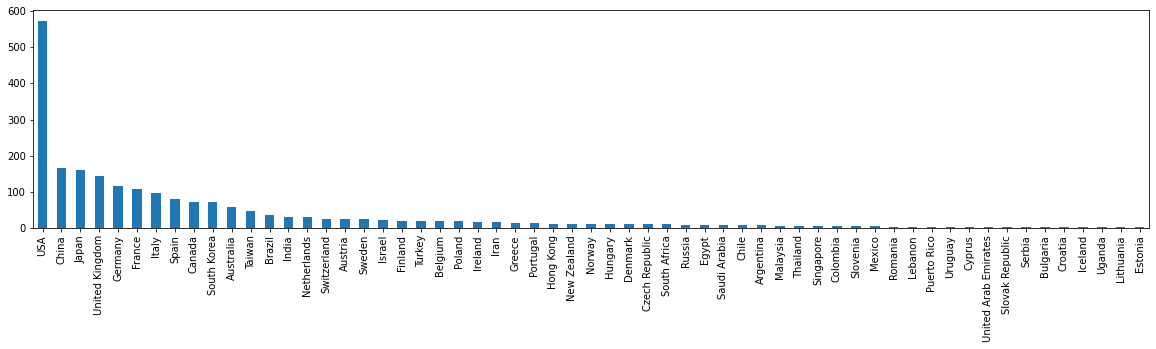

In [5]:
f,ax=plt.subplots(1,1,figsize=(20,4))
cwur['country'].value_counts().plot(kind='bar')

## Plotting top 20 universities in the world


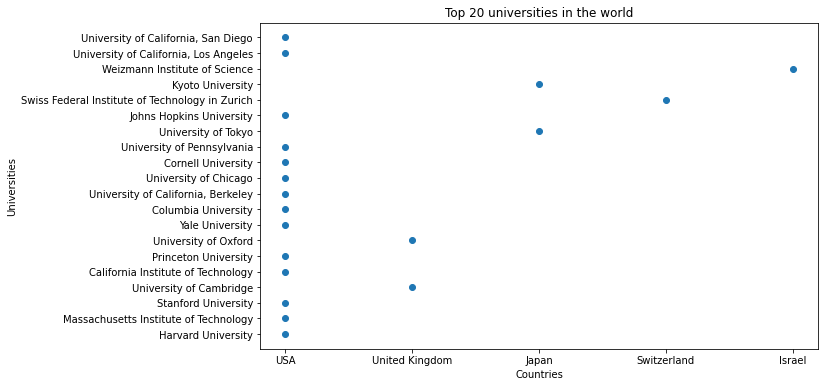

In [6]:
top_20=cwur.head(20)
f,ax=plt.subplots(1,1,figsize=(10,6))
plt.scatter(top_20.country,top_20.institution,) 
plt.xlabel('Countries')
plt.ylabel('Universities')
plt.title('Top 20 universities in the world')
plt.show()

## Quality of Education vs Alumni employment

In [7]:
df = cwur.iloc[:30, :];
cols_to_norm = ['quality_of_education','alumni_employment']
df[cols_to_norm] = StandardScaler().fit_transform(df[cols_to_norm])
quality_of_education = go.Scatter(
                    x = df.world_rank,
                    y = df.quality_of_education+1.5,
                    mode = "lines",
                    name = "quality_of_education",
                    marker = dict(color = 'rgb(16, 112, 2, 0.8)'),
                    text = df.institution);
alumni_employment = go.Scatter(
                    x = df.world_rank,
                    y = df.alumni_employment+1.5,
                    mode = "lines+markers",
                    name = "alumni_employment",
                    marker = dict(color = 'rgb(80, 26, 80, 0.8)'),
                    text = df.institution);

data = [quality_of_education,alumni_employment];
layout = dict(title = "Quality of education and alumni employment vs Top 20 Universities",width=700, height=400,
             legend=dict(yanchor="top",y=0.9,xanchor="left",x=0),
             xaxis = dict(title = "World Rank", ticklen = 5, zeroline = False,showgrid=False),
             yaxis=dict(showgrid=False,showticklabels=False,showline= True,autorange=False,
        range=[0,4.5]));
fig = dict(data = data, layout = layout);
iplot(fig)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1734: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



## Publications vs Citations

In [8]:
df = cwur.iloc[:40, :];
cols_to_norm = ['publications','citations']
df[cols_to_norm] = StandardScaler().fit_transform(df[cols_to_norm])
publications = go.Scatter(
                    x = df.world_rank,
                    y = df.publications+1.4,
                    mode = "lines",
                    name = "publications",
                    marker = dict(color = 'rgb(16, 112, 2, 0.8)'),
                    text = df.institution);

citations = go.Scatter(
                    x = df.world_rank,
                    y = df.citations+1.4,
                    mode = "lines+markers",
                    name = "citations",
                    marker = dict(color = 'rgb(80, 26, 80, 0.8)'),
                    text = df.institution);

data = [publications, citations];
layout = dict(title = "Publications and Citations vs World Rank of Top 20 Universities",width=700, height=400,
             legend=dict(yanchor="top",y=0.9,xanchor="left",x=0),
             xaxis = dict(title = "World Rank", ticklen = 5, zeroline = False,showgrid=False),
             yaxis=dict(showgrid=False,showticklabels=False,showline= True,autorange=False,
        range=[0,6]));

fig = go.Figure(data = data, layout = layout);
fig.show(renderer="colab")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1734: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



## Radar Plot

In [10]:
countries=cwur.country.unique()
country_dict=defaultdict(list)
cols_to_norm = ['quality_of_education','alumni_employment']
for i in countries:
  cond=cwur.country==i;
  df_country = cwur[cond]
  country_dict[i].append(1/df_country['quality_of_education'].mean())
  country_dict[i].append(1/df_country['citations'].mean())
  country_dict[i].append(1/df_country['publications'].mean())
  country_dict[i].append(1/df_country['alumni_employment'].mean())
  country_dict[i].append(1/df_country['quality_of_faculty'].mean())
fig = go.Figure(
    data=[
        go.Scatterpolar(r=country_dict['USA'], theta=['quality_of_education','citations','publications',
           'alumni_employment','quality_of_faculty'], fill='toself', name='USA'),
        go.Scatterpolar(r=country_dict['China'], theta=['quality_of_education','citations','publications',
           'alumni_employment','quality_of_faculty'], fill='toself', name='China'),
        go.Scatterpolar(r=country_dict['Japan'], theta=['quality_of_education','citations','publications',
           'alumni_employment','quality_of_faculty'], fill='toself', name='Japan'),
        go.Scatterpolar(r=country_dict['United Kingdom'], theta=['quality_of_education','citations','publications',
           'alumni_employment','quality_of_faculty'], fill='toself', name='United Kingdom')
    ],
    layout=go.Layout(
        polar={'radialaxis': {'visible': True}},
        showlegend=True
    )
)

fig.update_layout(
  polar=dict(
    radialaxis=dict(
      visible=False,
      range=[0, 0.0080]
    )),
    legend=dict(
    yanchor="top",
    y=0.9,
    xanchor="left",
    x=0.76
)
)
fig.show()

## UCSD

In [11]:
years=cwur.year.unique()
UCSD_dict=defaultdict(list)
cols_to_norm = ['quality_of_education','alumni_employment','citations','publications']
UCSD1=cwur[(cwur['institution']=='University of California, San Diego')]
for i in years:
  df_UCSD = UCSD1[(UCSD1['year']==i)]
  UCSD_dict[i].append(1/df_UCSD['quality_of_education'].mean())
  UCSD_dict[i].append(1/df_UCSD['citations'].mean())
  UCSD_dict[i].append(1/df_UCSD['publications'].mean())
  UCSD_dict[i].append(1/df_UCSD['alumni_employment'].mean())
  UCSD_dict[i].append(1/df_UCSD['quality_of_faculty'].mean())

categories=['quality_of_education','citations','publications',
           'alumni_employment','quality_of_faculty']
fig1 = go.Figure(
    data=[
        go.Scatterpolar(r=UCSD_dict[2012], theta=categories, fill='toself', name='2012'),
        go.Scatterpolar(r=UCSD_dict[2013], theta=categories, fill='toself', name='2013'),
        go.Scatterpolar(r=UCSD_dict[2014], theta=categories, fill='toself', name='2014'),
        go.Scatterpolar(r=UCSD_dict[2015], theta=categories, fill='toself', name='2015'),
    ],
    layout=go.Layout(
        polar={'radialaxis': {'visible': True}},
        showlegend=True
    )
)
fig1.update_layout(
  polar=dict(
    radialaxis=dict(
      visible=False,
      range=[0,0.14]
    )),
    legend=dict(
    yanchor="top",
    y=0.9,
    xanchor="left",
    x=0.76
)
)
fig1.show(renderer="colab")